In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import altair_saver
import glob
import os
import copy
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [3]:
def personal():
    return {
        'config': {
            'view': {
                'height': 300,
                'width': 400,
            },
            'range': {
                'category': {'scheme': 'set2'},
                'ordinal': {'scheme': 'set2'},
            },
            'legend': {
                'labelLimit': 0,
            },
            'background': 'white',
            'mark': {
                'clip': True,
            },
            'line': {
                'size': 3,
#                 'opacity': 0.4
            },


        }
    }

def publication():
    colorscheme = 'set2'
    stroke_color = '333'
    title_size = 24
    label_size = 20
    line_width = 5

    return {
        'config': {
            'view': {
                'height': 500,
                'width': 600,
                'strokeWidth': 0,
                'background': 'white',
            },
            'title': {
                'fontSize': title_size,
            },
            'range': {
                'category': {'scheme': colorscheme},
                'ordinal': {'scheme': colorscheme},
            },
            'axis': {
                'titleFontSize': title_size,
                'labelFontSize': label_size,
                'grid': False,
                'domainWidth': 5,
                'domainColor': stroke_color,
                'tickWidth': 3,
                'tickSize': 9,
                'tickCount': 4,
                'tickColor': stroke_color,
                'tickOffset': 0,
            },
            'legend': {
                'titleFontSize': title_size,
                'labelFontSize': label_size,
                'labelLimit': 0,
                'titleLimit': 0,
                'orient': 'top-left',
#                 'padding': 10,
                'titlePadding': 10,
#                 'rowPadding': 5,
                'fillColor': '#ffffff88',
#                 'strokeColor': 'black',
                'cornerRadius': 0,
            },
            'rule': {
                'size': 3,
                'color': '999',
                # 'strokeDash': [4, 4],
            },
            'line': {
                'size': line_width,
#                 'opacity': 0.4
            },
        }
    }

alt.themes.register('personal', personal)
alt.themes.register('publication', publication)
alt.themes.enable('personal')

ThemeRegistry.enable('personal')

In [4]:
import traceback
def load_jobs(pattern, subdir='exploration', title=None):    
    jobs = glob.glob(f'results/{subdir}/{pattern}')
    results = []
    for job in jobs:
        try:
            name = os.path.basename(os.path.normpath(job))
            train_data = pd.read_csv(job + '/train.csv')
            train_data['test'] = False
            test_data = pd.read_csv(job + '/test.csv')
            test_data['test'] = True
            data = pd.concat([train_data, test_data], sort=False)
            data['name'] = name
            results.append(data)
        except Exception as e:
#             traceback.print_exc()
            print(e)
    df = pd.concat(results, sort=False)
    if title is None:
        df['title'] = df['name'].str.replace(r'_seed\d', '')
    else:
        df['title'] = title
    return df.reset_index(drop=True)

def load_sac_results(env, task):
    sac_results = pd.read_csv('results/sac.csv')
    sac_results = sac_results[sac_results.env == f'{env}_{task}']
    sac_results['test'] = True
    sac_results['score'] = sac_results['episode_reward']
    sac_results['name'] = 'SAC'
    sac_results['title'] = 'SAC'
    return sac_results

In [5]:
def plot_with_bars(base_chart, y_col, test, extent='ci'):
    dummy_chart = base_chart.mark_circle(size=0, opacity=1).encode(
        y=f'mean({y_col}):Q',
    ).transform_filter(alt.datum.test == test)
    mean_chart = base_chart.encode(
        y=f'mean({y_col}):Q'
    ).transform_filter(alt.datum.test == test)
    err_chart = base_chart.encode(
        y=f'{y_col}:Q'
    ).transform_filter(alt.datum.test == test).mark_errorband(extent=extent)
    chart = dummy_chart + err_chart + mean_chart
    title_flag = ' [test]' if test else ' [train]'
    chart.title = base_chart.title + title_flag
    return chart
    

def make_base_chart(data, title, color, window=5):
    chart = alt.Chart(data, title=title).mark_line().encode(
        x=alt.X('episode', title='Episode'),
        color=color,
    ).transform_calculate(
        has_score=(alt.datum.score > 0.1),
    ).transform_window(
        sum_novelty='sum(novelty_score)',
        frame=[None, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_window(
        sum_score='sum(score)',
        frame=[None, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_window(
        count_score='sum(has_score)',
        frame=[None, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_window(
        rolling_mean_score='mean(score)',
        frame=[-window, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}]
    ).transform_window(
        rolling_mean_novelty='mean(novelty_score)',
        frame=[-window, 0],
        groupby=['name', 'test'],
        sort=[{'field': 'episode', 'order': 'ascending'}],
    ).transform_calculate(
        smoothed_score=((alt.datum.name == 'SAC') * alt.datum.score + 
                        (alt.datum.name != 'SAC') * alt.datum.rolling_mean_score)
    )
    return chart

In [84]:
alt.themes.enable('personal')
jobs = [
    load_sac_results('cartpole', 'swingup_sparse'),   
    load_jobs('ecp_kcweight_plr1e-4_sscale0.1*', subdir='exploration'),
    load_jobs('cart_knn*', subdir='exploration'),
    load_jobs('cart_approx*', subdir='exploration'),
]
data = pd.concat(jobs, sort=False)

N = 1000
subset = data
# subset = subset[((subset.episode % 5 == 0) & (subset.test)) | ((subset.episode % 3 == 0) & (~subset.test))]
subset = subset[(subset['episode'] <= N)]
chart = make_base_chart(
    subset, 
    title="Cartpole Swingup (sparse)", 
    color='title',
    window=5,
)

plot_with_bars(chart, 'elapsed', test=False) | plot_with_bars(chart, 'density_size', test=False)
# (plot_with_bars(chart, 'rolling_mean_score', test=False) | plot_with_bars(chart, 'smoothed_score', test=True)) & \
# (plot_with_bars(chart, 'sum_novelty', test=False) | plot_with_bars(chart, 'count_score', test=False)) & \
# (plot_with_bars(chart, 'policy_entropy', test=False) | plot_with_bars(chart, 'policy_entropy', test=True))

alt.HConcatChart(...)

In [87]:
alt.themes.enable('personal')
jobs = [
#     load_jobs('ecpkcdiagfix_sscale*', subdir='exploration'),
#     load_jobs('ecpkcdiagfix_plr*', subdir='exploration'),
#     load_jobs('ecpkcdiagfix_plr1e-4_sscale0.1_ascale1*', subdir='exploration'),
#     load_jobs('ecp_tab_20x2*', subdir='exploration', title='tabular count'),
#     load_jobs('cp_noexplore*', subdir='exploration', title='no exploration'),
    load_sac_results('cartpole', 'swingup_sparse'),   
    load_jobs('ecp_kcweight_plr1e-4_sscale0.1*', subdir='exploration'),
#     load_jobs('ecp_kcweight*', subdir='exploration'),
    load_jobs('cart_approx*', subdir='exploration'),
    load_jobs('cart_temp*', subdir='exploration'),
]
data = pd.concat(jobs, sort=False)

N = 100
subset = data
# subset = subset[((subset.episode % 5 == 0) & (subset.test)) | ((subset.episode % 3 == 0) & (~subset.test))]
subset = subset[(subset['episode'] <= N)]
chart = make_base_chart(
    subset, 
    title="Cartpole Swingup (sparse)", 
    color='title',
    window=5,
)

(plot_with_bars(chart, 'rolling_mean_score', test=False) | plot_with_bars(chart, 'smoothed_score', test=True)) & \
(plot_with_bars(chart, 'sum_novelty', test=False) | plot_with_bars(chart, 'count_score', test=False))# & \
# (plot_with_bars(chart, 'policy_entropy', test=False) | plot_with_bars(chart, 'policy_entropy', test=True))

alt.VConcatChart(...)

In [6]:
alt.themes.enable('personal')
jobs = [
    load_jobs('gw20_tab*', subdir='exploration', title='tabular count'),
    load_jobs('gw20_sscale*', subdir='exploration', title='kernel count (tiny)'),
    load_jobs('gw20fixedkernel_sscale0.001*', subdir='exploration', title='kernel count (tiny, fixed)'),
    load_jobs('gw20fixedkernel_sscale0.1*', subdir='exploration', title='kernel count (medium, fixed)'),
]
data = pd.concat(jobs, sort=False)
N = 100
subset = data
# subset = subset[((subset.episode % 5 == 0) & (subset.test)) | ((subset.episode % 3 == 0) & (~subset.test))]
subset = subset[(subset['episode'] <= N)]
chart = make_base_chart(
    subset, 
    title="Gridworld 20x20", 
    color='title',
    window=5,
)

(plot_with_bars(chart, 'rolling_mean_score', test=False) | plot_with_bars(chart, 'smoothed_score', test=True)) & \
(plot_with_bars(chart, 'sum_novelty', test=False).interactive() | plot_with_bars(chart, 'count_score', test=False)) & \
plot_with_bars(chart, 'policy_entropy', test=True)

alt.VConcatChart(...)

In [8]:
alt.themes.enable('personal')
jobs = [
    load_jobs('arxiv2_pv100_seed*', subdir='exploration', title='tabular_density'),
#     load_jobs('explore_pv100_kcount*', subdir='exploration'),
#     load_jobs('explore_pv100_k*clippednum*', subdir='exploration'),
#     load_jobs('epv100kc_scale*', subdir='exploration'),
#     load_jobs('epv100kc_sscale*', subdir='exploration'),
#     load_jobs('epv100kcfix_sscale*', subdir='exploration'),
#     load_jobs('epv100kcrefix_sscale*', subdir='exploration'),
    load_jobs('epv100kcdiag_sscale*', subdir='exploration'),
]
data = pd.concat(jobs, sort=False)
N = 200
subset = data
# subset = subset[((subset.episode % 5 == 0) & (subset.test)) | ((subset.episode % 3 == 0) & (~subset.test))]
subset = subset[(subset['episode'] <= N)]
chart = make_base_chart(
    subset, 
    title="Point Velocity", 
    color='title',
    window=5,
)

(plot_with_bars(chart, 'rolling_mean_score', test=False) | plot_with_bars(chart, 'smoothed_score', test=True)) & \
(plot_with_bars(chart, 'sum_novelty', test=False) | plot_with_bars(chart, 'count_score', test=False)) & \
plot_with_bars(chart, 'policy_entropy', test=True)

alt.VConcatChart(...)

In [44]:
alt.themes.enable('personal')
jobs = [
#     load_jobs('epv100kcdiag_sscale*', subdir='exploration'),
#     load_jobs('kctest*', subdir='exploration', title='weighted kernel'),
#     load_jobs('pv100_kctest*', subdir='exploration', title='weighted kernel'),
#     load_jobs('pv100_kcrevert*', subdir='exploration', title='full kernel'),
    load_jobs('pv100_speed*', subdir='exploration', title='small vis'),
    load_jobs('pv_knn_timing*', subdir='exploration'),
]
data = pd.concat(jobs, sort=False)
N = 10
subset = data
# subset = subset[((subset.episode % 5 == 0) & (subset.test)) | ((subset.episode % 3 == 0) & (~subset.test))]
subset = subset[(subset['episode'] <= N)]
chart = make_base_chart(
    subset, 
    title="PV100", 
    color='title',
    window=5,
)

# (plot_with_bars(chart, 'rolling_mean_score', test=False) | plot_with_bars(chart, 'smoothed_score', test=True)) & \
# (plot_with_bars(chart, 'sum_novelty', test=False).interactive() | plot_with_bars(chart, 'count_score', test=False)) & \
plot_with_bars(chart, 'elapsed', test=False)

alt.LayerChart(...)

In [66]:
alt.themes.enable('personal')
jobs = [
    load_sac_results('cartpole', 'swingup'),
]
data = pd.concat(jobs, sort=False)

subset = data
subset = subset[(subset['episode'] <= 1000)]
chart = make_base_chart(
    subset, 
    title="Cartpole Swingup (dense)", 
    color='name')

# chart = plot_with_bars(chart, 'rolling_mean_score', test=True)
chart.encode(y='score').interactive()


alt.Chart(...)

In [68]:
data.seed.unique()

array([1])

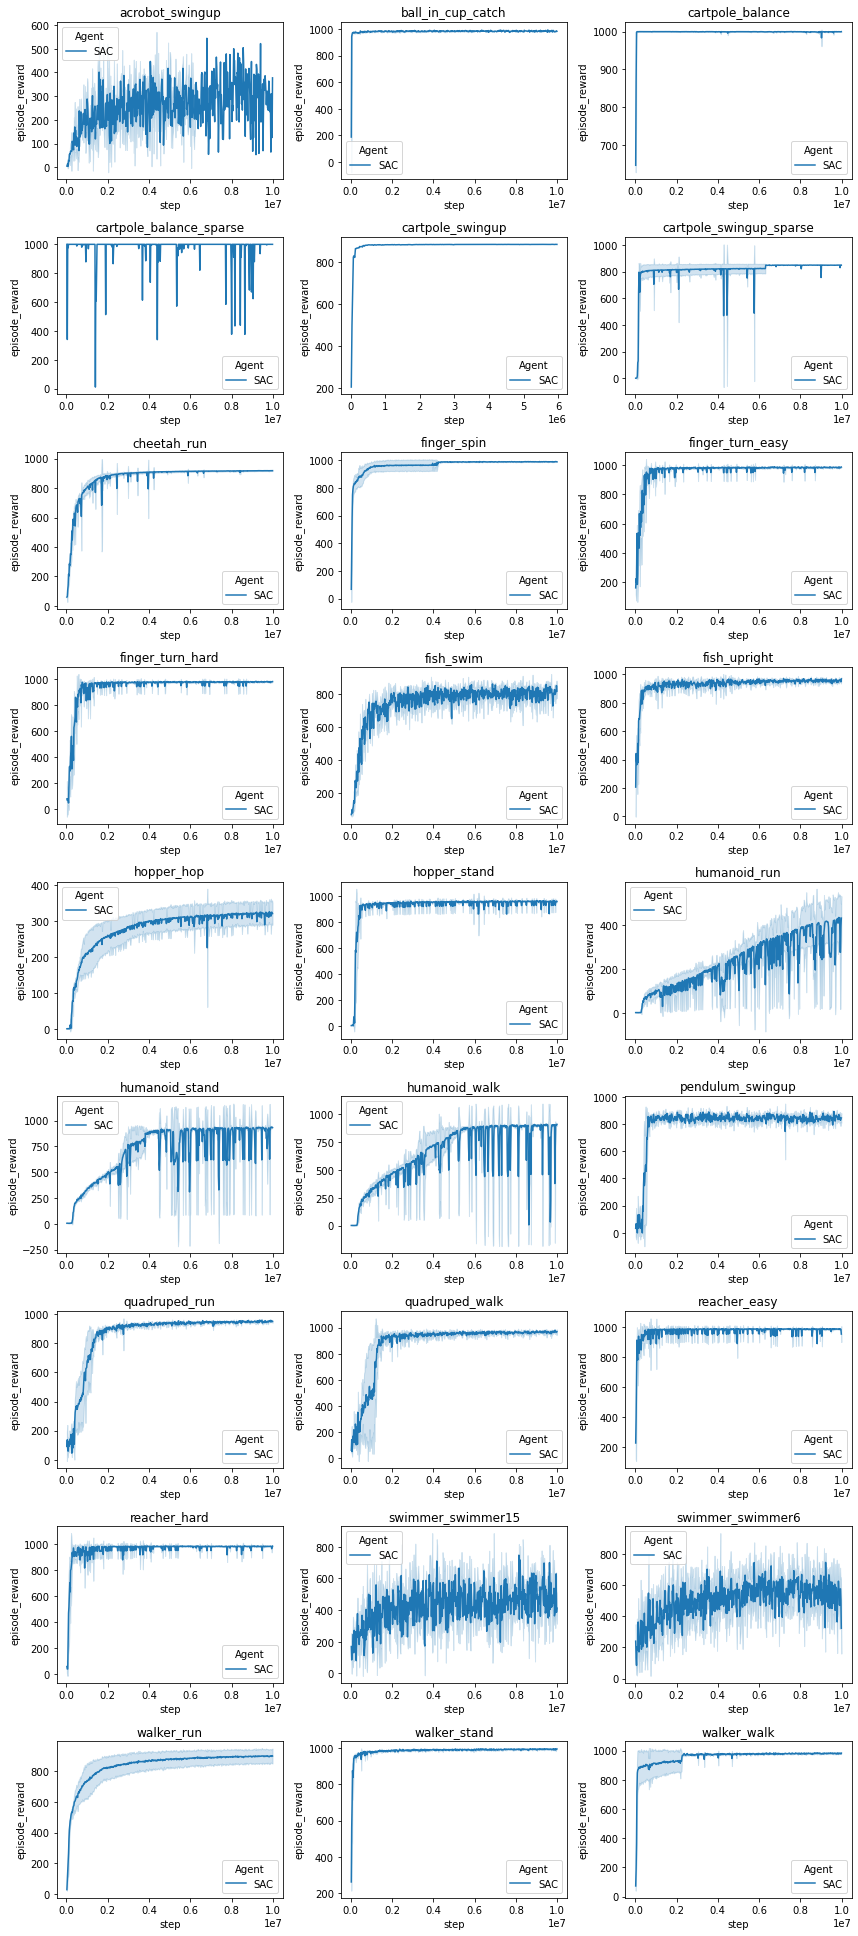

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

def plot(df, base=None, key='episode_reward'):
    envs = np.sort(df.env.unique())
    ncol = 3
    assert envs.shape[0] % ncol == 0
    nrow = envs.shape[0] // ncol
    fig, axs = plt.subplots(nrow, ncol, figsize=(4 * ncol, 3 * nrow))
    #runs = sorted([str(x) for x in df.run.unique()])
    for idx, env in enumerate(envs):
        data = df[df['env'] == env]
        row = idx // ncol
        col = idx % ncol
        ax = axs[row, col]
        hue_order = np.sort(data.Agent.unique())
        #import ipdb; ipdb.set_trace()
        sns.lineplot(x='step', y=key, data=data, ci='sd', hue='Agent', hue_order=hue_order, ax=ax)
        #sns.lineplot(x=‘step’, y=key, data=data, ci=‘sd’, hue=‘run_id’, ax=ax, palette=sns.color_palette(‘Blues’)[3:4])
        if base is not None:
            if env in base:
                val = base[env]['d4pg']
                ax.axhline(val, ls='--', color='black', label='D4PG ($10^8$ steps)')
                ax.legend()
        ax.set_title(f'{env}')
        #ax.set_xlim(0, 10000000)
        #ax.set_ylim(0.0, 1050.0)
        #ax.legend_.remove()
    plt.tight_layout()
    plt.show()
plot(pd.read_csv('results/sac.csv'))